In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set dataset path
dataset_path = "./Image_Train/"
image_size = (224, 224)  # Resize images to 224x224 (common input size for models)

# Create lists to store data and labels
images = []
labels = []

# Define a function to load and preprocess images
def load_images_from_folder(folder_path, label):
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        # Read the image
        img = cv2.imread(img_path)
        if img is not None:
            # Resize the image
            img_resized = cv2.resize(img, image_size)
            # Append image and label to the lists
            images.append(img_resized)
            labels.append(label)

# Load dataset (Example: Assuming folders are structured as uniform(without) and non_uniform(with) background.)
load_images_from_folder(os.path.join(dataset_path, "without_background_11"), label=1)      # 1 for uniform background
load_images_from_folder(os.path.join(dataset_path, "with_background"), label=0) # 0 for non-uniform background

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize images to [0, 1]
images = images / 255.0

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print dataset statistics
print(f"Total images: {len(images)}")
print(f"Training set: {len(X_train)}")
print(f"Testing set: {len(X_test)}")


Total images: 291
Training set: 232
Testing set: 59


In [2]:
images.shape

(291, 224, 224, 3)

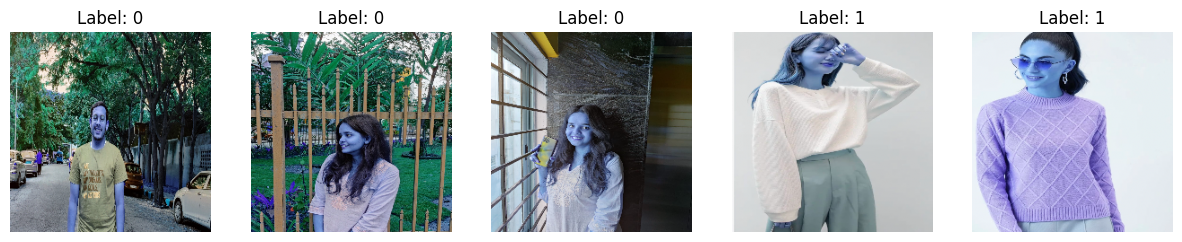

In [3]:
# Display sample images with their labels
def display_samples(X, y, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[i])
        plt.title(f"Label: {y[i]}")
        plt.axis("off")
    plt.show()

# Show sample images from training set
display_samples(X_train, y_train)

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Calculate class weights to handle imbalance in the dataset
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Model Building (same as before)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
epochs = 30
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=32,
    class_weight=class_weights  # Apply class weights to handle class imbalance
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the trained model
model.save('background_classifier.h5')

# Predict on test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions from one-hot encoding to labels
y_true = np.argmax(y_test, axis=1)  # Convert true labels from one-hot encoding to labels

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 598ms/step - accuracy: 0.5635 - loss: 0.9767 - val_accuracy: 0.8814 - val_loss: 0.2992
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.9150 - loss: 0.2233 - val_accuracy: 0.9153 - val_loss: 0.1819
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.9557 - loss: 0.1257 - val_accuracy: 0.9153 - val_loss: 0.1743
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.9556 - loss: 0.0718 - val_accuracy: 0.9153 - val_loss: 0.1452
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.9661 - loss: 0.0810 - val_accuracy: 0.9492 - val_loss: 0.1213
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.9830 - loss: 0.0394 - val_accuracy: 0.9322 - val_loss: 0.1063
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.9952 - loss: 0.0288 - val_accuracy: 0.9322 - val_loss: 0.1060
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.9817 - loss: 0.0443 - val_accuracy: 0.9492 - val_loss:

Test Accuracy: 0.95
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        41
           1       0.89      0.94      0.92        18

    accuracy                           0.95        59
   macro avg       0.93      0.95      0.94        59
weighted avg       0.95      0.95      0.95        59

Confusion Matrix:
[[39  2]
 [ 1 17]]


### Tested on dataset with uniform background(without background). 

In [7]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('background_classifier.h5')

# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at path: {image_path}")
    
    # Resize the image to match the input size of the model
    img_resized = cv2.resize(img, target_size)
    
    # Normalize the image to [0, 1]
    img_normalized = img_resized / 255.0
    
    # Add batch dimension (model expects input with shape (1, 224, 224, 3))
    img_batch = np.expand_dims(img_normalized, axis=0)
    
    return img_batch

# Function to predict the label of an image
def predict_image_label(image_path):
    # Preprocess the image
    img_batch = preprocess_image(image_path)
    
    # Make a prediction
    prediction = model.predict(img_batch)
    
    # Get the predicted label (0 or 1)
    predicted_label = np.argmax(prediction, axis=1)[0]
    
    # Map the predicted label to the class names based on the label structure
    class_labels = {0: 'Non-Uniform Background (with_background)', 1: 'Uniform Background (without_background)'}
    
    return class_labels[predicted_label]

# Path to the folder containing images to be tested
image_folder_path = r"C:\Users\neham\OneDrive\Documents\Digio_assignment\first_assignment\Image_Test\without_background"

# Loop through the images in the folder and predict the label for each
for filename in os.listdir(image_folder_path):
    image_path = os.path.join(image_folder_path, filename)
    
    try:
        # Get the predicted label for the image
        label = predict_image_label(image_path)
        print(f"Image: {filename}, Predicted Label: {label}")
    except Exception as e:
        print(f"Error processing {filename}: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
Image: ABHAY_17.jpeg, Predicted Label: Non-Uniform Background (with_background)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: ayusha_17.jpeg, Predicted Label: Uniform Background (without_background)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: Neha_16.jpeg, Predicted Label: Uniform Background (without_background)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: Sameer_16.jpg, Predicted Label: Uniform Background (without_background)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: WhatsApp Image 2025-01-18 at 16.21.58.jpeg, Predicted Label: Uniform Background (without_background)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: WhatsApp Image 2025-01-18 at 16.22.43.jpeg, Predicted Label: Uniform Background (without_background)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: WhatsApp Image 2025-01-18 at 16.23.31.jpeg, Predicted Label: Uniform Background (without_background)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: WhatsApp Image 2025-01-18 at 16.24.16.jpeg, Pre